In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, Flatten, Reshape, SqueezeN, Index, EmbedLookup

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   #'coulomb',
                                                                   #'aromatic',
                                                                   #'degree',
                                                                  ],
                                                             #'edge_idx': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             #'mulliken': [Pad1d(29)],
                                             'coulomb': [Reshape((-1)), Pad1d(29*29)],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 100, #non-random subset for testing,
                              'use_pickle': False,
                              'n_conformers': 10}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  100
total uncharacterized molecules removed:  3
total molecules created:  97
CDataset created...


{'model_input': {'X': array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
  'embed': [[array([5, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0])],
   [array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0])]]},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
molecules scanned:  10001
molecules created:  9671
total molecules scanned:  10330
total uncharacterized molecules removed:  281
total molecules created:  9719
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:05.607774
epoch: 0, lr: 0.01
train loss: 51.60177848474035, val loss: 17.783116828070746
learning time: 0:00:18.963668
epoch: 3, lr: 0.01
train loss: 14.642020553912756, val loss: 16.76035230424669
learning time: 0:00:32.304147
epoch: 6, lr: 0.01
train loss: 12.989564049918696, val loss: 11.717710526784261
learning time: 0:00:45.902715
epoch: 9, lr: 0.005
train loss: 10.872751856749913, val loss: 10.29166915681627
test loss: 9.891529824998644
learning time: 0:00:46.395315


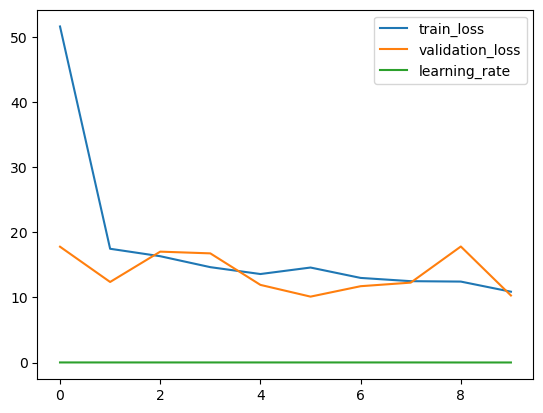

In [2]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'coulomb',
                                                                   'aromatic',
                                                                   'degree',
                                                                  ],
                                                             #'edge_idx': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             #'mulliken': [Pad1d(29)],
                                             'coulomb': [Reshape((-1)), Pad1d(29*29)],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_test_ds', #load if exists otherwise create
                              'n_conformers': 10}}

model_params = {'in_channels': 29+29+29+29*29+8*29+29*8, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,8,0,True),('chirality',4,8,0,True)],
               }      

metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2, #create random subset
                }

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=False, batch_size=32, epochs=10, save_model=True)

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from state_dict...
loading embedding weights...
running model on gpu...
learning time: 0:00:05.306018
epoch: 0, lr: 0.01
train loss: 13.00249162709938, val loss: 10.787685532040067
test loss: 12.08723619249132
learning time: 0:00:10.195951


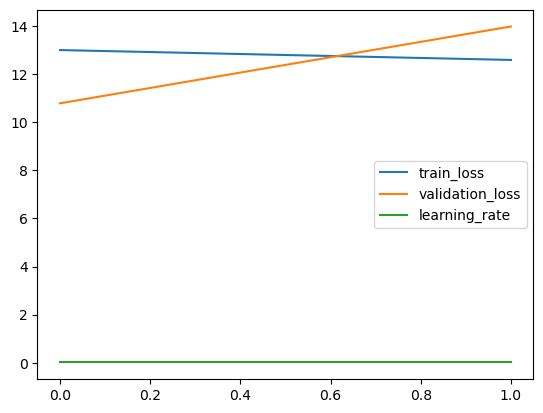

In [3]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'coulomb',
                                                                   'aromatic',
                                                                   'degree',
                                                                  ],
                                                             #'edge_idx': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             #'mulliken': [Pad1d(29)],
                                             'coulomb': [Reshape((-1)), Pad1d(29*29)],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_test_ds', #load if exists otherwise create
                              'n_conformers': 10}}

model_params = {'in_channels': 29+29+29+29*29+8*29+29*8, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,8,0,True),('chirality',4,8,0,True)],
               }      

metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2, #create random subset
                }

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=False, batch_size=32, epochs=2, save_model=True, 
          load_model='20240417_0916.pth', load_embed='20240417_0916')

In [3]:
import numpy as np
np.load('./models/20240417_0916_0_embedding_weight.npy').shape

(9, 8)

In [ ]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

In [ ]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(1)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

In [ ]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((29,29)),Reshape((-1))],
                                             'U0': [SqueezeN()]},
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False}}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['aromatic','degree',
                                                                   'charge','coulomb'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'n_conformers': 10,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False,
                              'flatten': True}}

model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

model_params = {'in_channels': 29+29+29+29*29+29*16+29*16, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',5,16,0,True)]
               }      

metrics_params = {'report_interval': 1,
                  'log_plot': False}

metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                 
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

opt_params = {'lr': 0.01}



l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=True, batch_size=128, epochs=20)

In [ ]:
#example cosmosis/qchem QM9 dataset with filter, rdkit data augmentation, 
#multiple conformations, embeddings and custom model 
rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['aromatic','degree',
                                                                   'charge','coulomb'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'n_conformers': 10,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False,
                              'flatten': True}}


model_params = {'in_channels': 29+29+29+29*29+29*16+29*16, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',5,16,0,True)]
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 128, 
                'out_channels': 1,
                'depth': 1,
                'convolution': 'NetConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
                'edge_features': 4,
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=10)

In [ ]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': False,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

In [ ]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': True,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=2)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'model_name': 'GraphSAGE',
                'softmax': None,
                'pool': 'MeanAggregation',
                'ffnet': True,
                'in_channels': 256, #ffnet params
                'hidden': 256, 
                'out_channels': 1, 
                'pyg_params': {'in_channels': 11, #GraphSAGE params
                               'hidden_channels': 256,
                               'num_layers': 2,
                               'out_channels': 256,
                               'dropout': .1,
                               'norm': 'BatchNorm'}}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0)])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=2)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(0)],
                                             'x': [Pad((29,11)), Flatten()]},
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

qm7b = QM7b(**ds_params['train_params'])
qm7b[1]

In [ ]:
qm7b[1]['model_input']['X'].shape

In [ ]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


In [ ]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Pad((23,23)), Flatten()]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [ ]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Pad((63,63)), Flatten()]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)